📊 Mean Absolute Error (MAE): 0.27
📊 R² Score: 1.00
            date   district                          disease  actual_cases  \
18744 2023-06-12     Nagaon                          Cholera             6   
18745 2023-06-12     Nagaon                          Typhoid            19   
18746 2023-06-12     Nagaon  Acute Gastroenteritis/Dysentery            33   
18747 2023-06-12     Nagaon                    Hepatitis A/E            19   
18748 2023-06-12     Nagaon                    Leptospirosis             3   
18749 2023-06-12    Barpeta                    Leptospirosis             5   
18750 2023-06-12    Barpeta  Acute Gastroenteritis/Dysentery            46   
18751 2023-06-12   Morigaon  Acute Gastroenteritis/Dysentery            32   
18752 2023-06-12  Charaideo                          Cholera             3   
18753 2023-06-12   Morigaon                          Cholera             3   

       predicted_cases  
18744         5.862589  
18745        19.146229  
18746        32

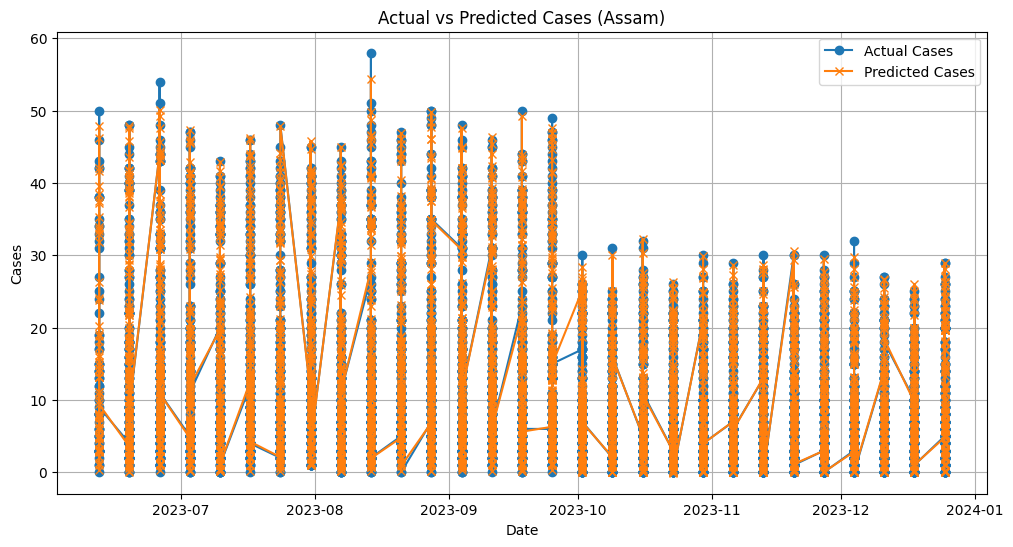

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# -------------------------
# 1. Load & preprocess data
# -------------------------
df = pd.read_excel(r"C:\Users\PINKY\OneDrive\Desktop\SIH\data\assam_data.xlsx")   # your Assam data file

# Encode categorical variables
lbl_district = LabelEncoder()
lbl_disease = LabelEncoder()

df['district_enc'] = lbl_district.fit_transform(df['district'])
df['disease_enc'] = lbl_disease.fit_transform(df['disease'])

# Convert date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values("date")

# Time features
df['dayofyear'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.isocalendar().week.astype(int)
df['weekday'] = df['date'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)

# -------------------------
# 2. Feature engineering
# -------------------------
env_cols = [
    'turbidity_NTU','water_surface_temp_C','chlorophyll_a_mg_m3',
    'NDWI','NDVI','EVI','SPM_mg_L',
    'surface_reflectance_B3','surface_reflectance_B4','surface_reflectance_B5'
]

# Create lag & rolling features
for lag in [1,2,3,7,14]:
    df[f'lag_{lag}'] = df.groupby(['district','disease'])['cases'].shift(lag)

for window in [3,7,14]:
    df[f'roll_mean_{window}'] = df.groupby(['district','disease'])['cases'].shift(1).rolling(window).mean()
    df[f'roll_std_{window}'] = df.groupby(['district','disease'])['cases'].shift(1).rolling(window).std()

df['cases_diff_1'] = df.groupby(['district','disease'])['cases'].diff(1)

df = df.dropna().reset_index(drop=True)

# -------------------------
# 3. Train-test split
# -------------------------
feature_cols = (
    ['district_enc','disease_enc','dayofyear','month','week','weekday','is_weekend'] +
    [f'lag_{l}' for l in [1,2,3,7,14]] +
    [f'roll_mean_{w}' for w in [3,7,14]] +
    [f'roll_std_{w}' for w in [3,7,14]] +
    ['cases_diff_1'] + env_cols
)

X = df[feature_cols]
y = df['cases']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# -------------------------
# 4. Train model
# -------------------------
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# -------------------------
# 5. Predictions
# -------------------------
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 Mean Absolute Error (MAE): {mae:.2f}")
print(f"📊 R² Score: {r2:.2f}")

# -------------------------
# 6. Compare actual vs predicted
# -------------------------
results = pd.DataFrame({
    "date": df.loc[X_test.index, "date"],
    "district": df.loc[X_test.index, "district"],
    "disease": df.loc[X_test.index, "disease"],
    "actual_cases": y_test.values,
    "predicted_cases": y_pred
})

print(results.head(10))

# -------------------------
# 7. Plot comparison
# -------------------------
plt.figure(figsize=(12,6))
plt.plot(results["date"], results["actual_cases"], label="Actual Cases", marker='o')
plt.plot(results["date"], results["predicted_cases"], label="Predicted Cases", marker='x')
plt.title("Actual vs Predicted Cases (Assam)")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.show()


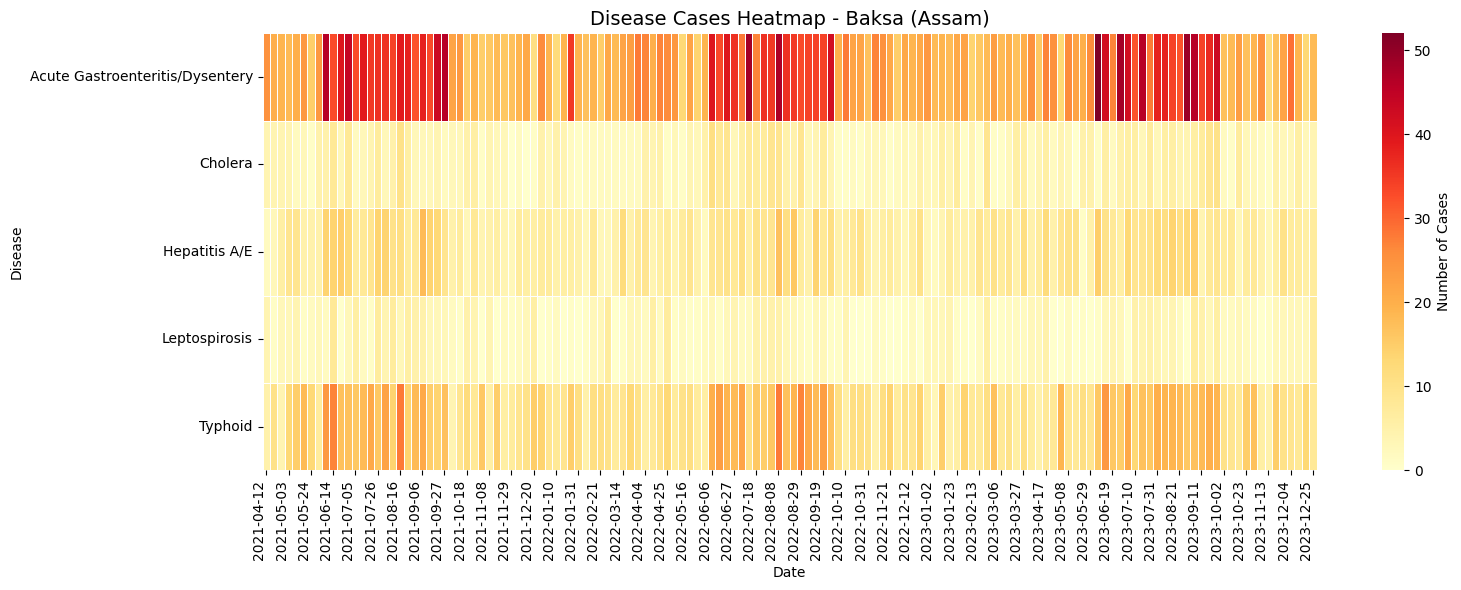

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------
# Choose a district
# -------------------------
district_name = "Baksa"   # 🔹 change this to your district

df_district = df[df['district'] == district_name].copy()

# Keep only the date part
df_district['date'] = pd.to_datetime(df_district['date']).dt.date

# Pivot: diseases as rows, dates as columns
heatmap_data = df_district.pivot_table(
    index="disease",
    columns="date",
    values="cases",
    aggfunc="sum",
    fill_value=0
)

plt.figure(figsize=(16, 6))
sns.heatmap(
    heatmap_data,
    cmap="YlOrRd",
    linewidths=0.5,
    cbar_kws={'label': 'Number of Cases'}
)
plt.title(f"Disease Cases Heatmap - {district_name} (Assam)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Disease")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()


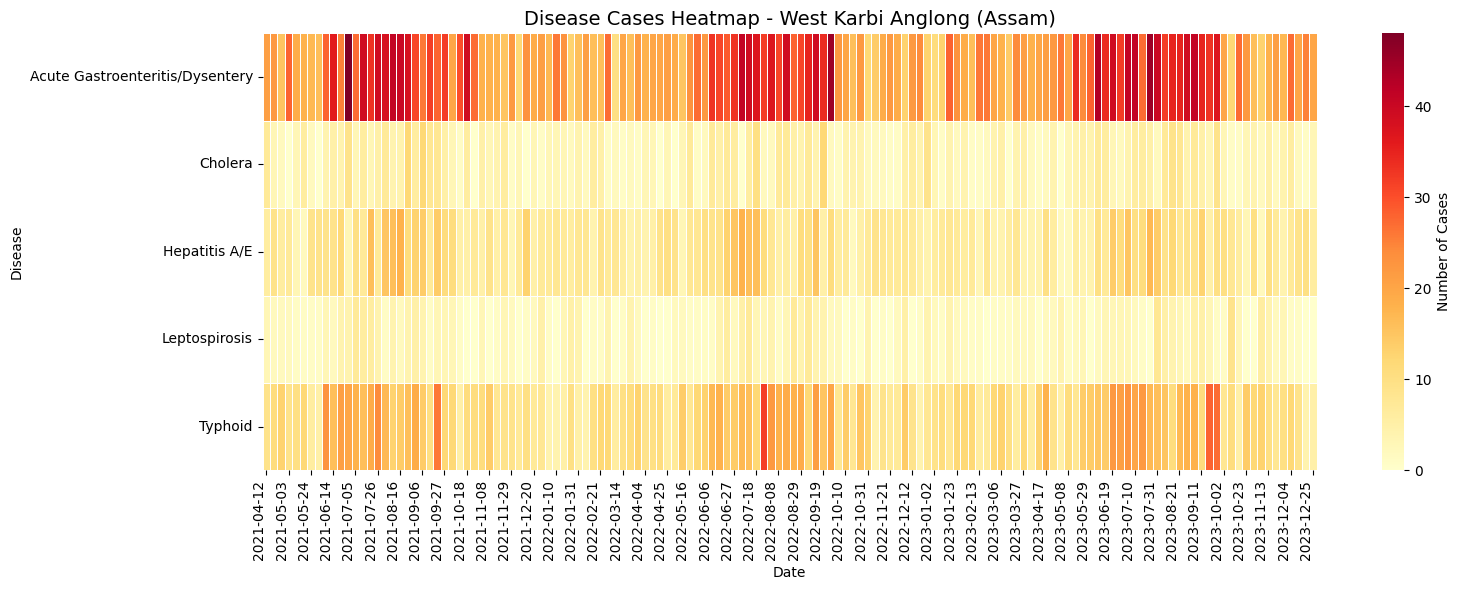

In [10]:
district_name = "West Karbi Anglong"   # 🔹 change this to your district

df_district = df[df['district'] == district_name].copy()

# Keep only the date part
df_district['date'] = pd.to_datetime(df_district['date']).dt.date

# Pivot: diseases as rows, dates as columns
heatmap_data = df_district.pivot_table(
    index="disease",
    columns="date",
    values="cases",
    aggfunc="sum",
    fill_value=0
)

plt.figure(figsize=(16, 6))
sns.heatmap(
    heatmap_data,
    cmap="YlOrRd",
    linewidths=0.5,
    cbar_kws={'label': 'Number of Cases'}
)
plt.title(f"Disease Cases Heatmap - {district_name} (Assam)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Disease")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()


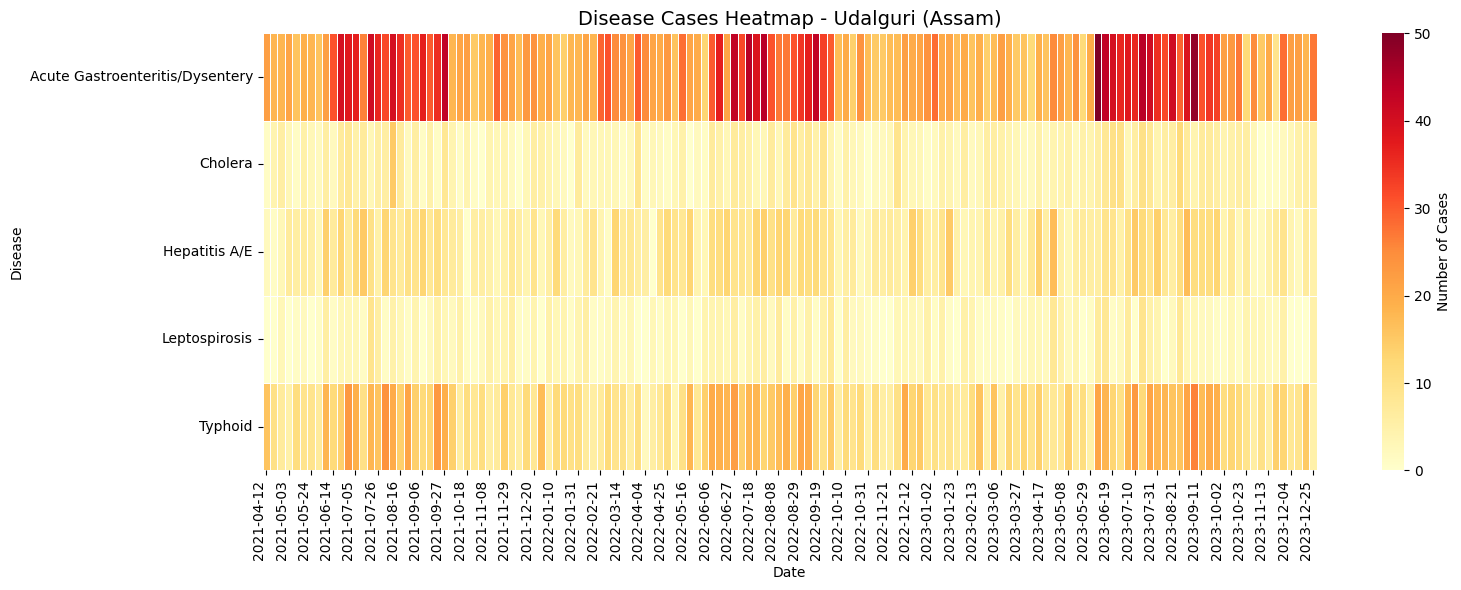

In [11]:
district_name = "Udalguri"   # 🔹 change this to your district

df_district = df[df['district'] == district_name].copy()

# Keep only the date part
df_district['date'] = pd.to_datetime(df_district['date']).dt.date

# Pivot: diseases as rows, dates as columns
heatmap_data = df_district.pivot_table(
    index="disease",
    columns="date",
    values="cases",
    aggfunc="sum",
    fill_value=0
)

plt.figure(figsize=(16, 6))
sns.heatmap(
    heatmap_data,
    cmap="YlOrRd",
    linewidths=0.5,
    cbar_kws={'label': 'Number of Cases'}
)
plt.title(f"Disease Cases Heatmap - {district_name} (Assam)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Disease")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()


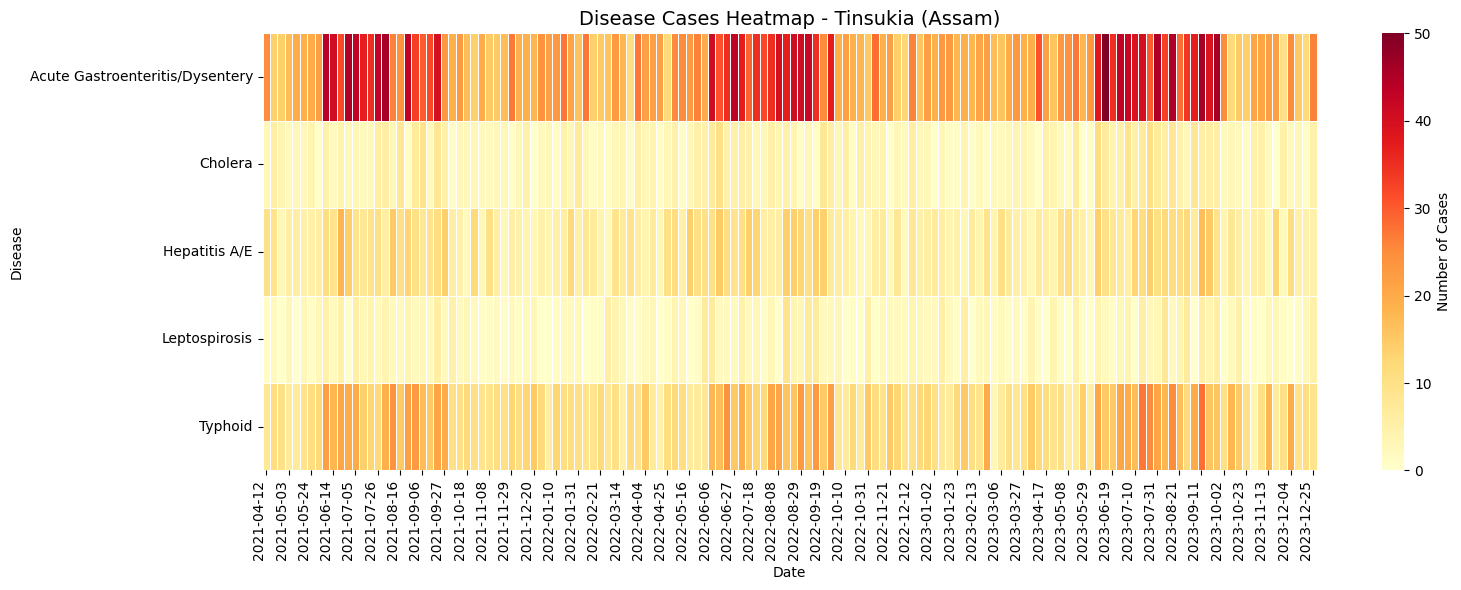

In [12]:
district_name = "Tinsukia"   # 🔹 change this to your district

df_district = df[df['district'] == district_name].copy()

# Keep only the date part
df_district['date'] = pd.to_datetime(df_district['date']).dt.date

# Pivot: diseases as rows, dates as columns
heatmap_data = df_district.pivot_table(
    index="disease",
    columns="date",
    values="cases",
    aggfunc="sum",
    fill_value=0
)

plt.figure(figsize=(16, 6))
sns.heatmap(
    heatmap_data,
    cmap="YlOrRd",
    linewidths=0.5,
    cbar_kws={'label': 'Number of Cases'}
)
plt.title(f"Disease Cases Heatmap - {district_name} (Assam)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Disease")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()


In [6]:
df["date"]

0       2021-04-12
1       2021-04-12
2       2021-04-12
3       2021-04-12
4       2021-04-12
           ...    
23425   2023-12-25
23426   2023-12-25
23427   2023-12-25
23428   2023-12-25
23429   2023-12-25
Name: date, Length: 23430, dtype: datetime64[ns]

In [ ]:
#1 year data(of any district) ---> prediction
#map predicted and actual

In [16]:
#Disease classification

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Prepare data
X = df[feature_cols]
y_class = df['disease_enc']  # target for classification

# Split the data
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_class, test_size=0.2, shuffle=False
)

# Train a classifier (Random Forest as example)
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)
clf.fit(X_train_cls, y_train_cls)

# Predictions
y_pred_cls = clf.predict(X_test_cls)

# Evaluation
print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print(classification_report(y_test_cls, y_pred_cls, target_names=lbl_disease.classes_))

# Example: map predictions back to disease names
predicted_diseases = lbl_disease.inverse_transform(y_pred_cls)
print(predicted_diseases[:10])


Accuracy: 1.0
                                 precision    recall  f1-score   support

Acute Gastroenteritis/Dysentery       1.00      1.00      1.00       939
                        Cholera       1.00      1.00      1.00       937
                  Hepatitis A/E       1.00      1.00      1.00       936
                  Leptospirosis       1.00      1.00      1.00       937
                        Typhoid       1.00      1.00      1.00       937

                       accuracy                           1.00      4686
                      macro avg       1.00      1.00      1.00      4686
                   weighted avg       1.00      1.00      1.00      4686

['Cholera' 'Typhoid' 'Acute Gastroenteritis/Dysentery' 'Hepatitis A/E'
 'Leptospirosis' 'Leptospirosis' 'Acute Gastroenteritis/Dysentery'
 'Acute Gastroenteritis/Dysentery' 'Cholera' 'Cholera']


In [17]:
results = pd.DataFrame({
    "date": df.loc[X_test_cls.index, "date"],
    "district": df.loc[X_test_cls.index, "district"],
    "actual_disease": df.loc[X_test_cls.index, "disease"],
    "predicted_disease": lbl_disease.inverse_transform(y_pred_cls),
    "actual_cases": df.loc[X_test_cls.index, "cases"],
    "predicted_cases": model.predict(X_test_cls)  # Using regression model here
})

print(results.head())

            date district                   actual_disease  \
18744 2023-06-12   Nagaon                          Cholera   
18745 2023-06-12   Nagaon                          Typhoid   
18746 2023-06-12   Nagaon  Acute Gastroenteritis/Dysentery   
18747 2023-06-12   Nagaon                    Hepatitis A/E   
18748 2023-06-12   Nagaon                    Leptospirosis   

                     predicted_disease  actual_cases  predicted_cases  
18744                          Cholera             6         5.862589  
18745                          Typhoid            19        19.146229  
18746  Acute Gastroenteritis/Dysentery            33        32.980736  
18747                    Hepatitis A/E            19        18.885601  
18748                    Leptospirosis             3         2.915692  


In [18]:
import joblib

# Export the classification model
joblib.dump(clf, 'disease_classifier.pkl')

# Export the label encoder too (important for decoding later)
joblib.dump(lbl_disease, 'label_encoder_disease.pkl')

# Optionally, export the regression model as well
joblib.dump(model, 'case_regressor.pkl')

# And the district label encoder
joblib.dump(lbl_district, 'label_encoder_district.pkl')


['label_encoder_district.pkl']